# Introduction

This is part 2 of a two part 'end-of-phase' project with Flatiron School. In the previous notebook I conducted an descriptive and inferential analysis of the dataset that I will be using in this model creation.

## Table of Contents
- [Introduction](#Introduction)
- [Recap](#Recap)
- [Imports and Cleaning](#Imports-and-Cleaning)
- [Data Preprocessing](#Data-Preprocessing)
- [Model](#Model)
    - [Shotgun Method](#Shotgun-Method)
    - [Logistic Regressor](#Logistic-Regressor)
    - [Bagging Classifier](#Bagging-Classifier)
    - [Extra Trees Classifier](#Extra-Trees-Classifier)
- [Model Tuning](#Model-Tuning)
- [The Pipeline](#The-Pipeline)
- [Final Pipeline](#Final-Pipeline)
- [Summery](#Summery)

# Recap

## Descriptive Analysis
In the first notebook, I asked and answered many descriptive analysis questions, those of which included the following
* On average, how much sleep does someone with a sleeping disorder recieve compared someone with no sleeping disorder?
* On average, what is the quality of sleep that someone with a sleeping disorder recieves compared to those without a sleeping disorder?
* What distribution of Males and Females in my dataset are diagnosed with sleeping disorders?
* What percentage of my dataset has Insomnia?
* Of those with Insomnia, What percentage is male vs female?
* What is the distribution of age for patients with insomnia in my dataset?

In addition to those questions, I also asked a number of demographic related questions related to those who have insomnia. Demographics such as gender, age, and profession were all asked and answered.

After getting an asked and answering all of the questions listed, I felt confident that I was ready to move onto my inferential analysis.

In my inferential anaylsis I conducted hypothesis tests on the following statistic which are accompanied by its result.


## Inferential Analysis

### With vs Without Insomnia Two Sample T-Tests

These tests were two sampl t-tests in which I grouped my data by patients with insomnia (I) and without insomnia (NI) and found the mean ($\mu$) for each test variable and tested for a significant difference with a significance level (alpha) of 0.05. 

Null Hypothesis ($H_0$): $\mu_{I}$ = $\mu_{NI}$

Alternate Hypothesis ($H_A$): $\mu_{I}$ $\neq$ $\mu_{NI}$

#### Sleep Duration

In this test, I calculated the means and performed a two sample t-test. In this test, the mean ($\mu$) refers to the mean sleep duration for each group.

Result: **Reject the Null Hypothesis.** Although we observed a significant enough difference in sleep duration to reject the null hypothesis, this does not mean that the reason for the significant difference in sleep duration is due to having insomnia or not having insomnia. We simply observed that the difference exists.

#### Quality of Sleep

In this test, I calculated the means and performed a two sample t-test. In this test, the mean ($\mu$) refers to the mean quality of sleep for each group.

Result: **Reject the Null Hypothesis.** Although we observed a significant enough difference in quality of sleep to reject the null hypothesis, this does not mean that the reason for the significant difference in quality of sleep is due to having insomnia or not having insomnia. We simply observed that the difference exists.

#### Physical Activity Level

In this test, I calculated the means and performed a two sample t-test. In this test, the mean ($\mu$) refers to the mean physical activity level for each group.

Result: **Reject the Null Hypothesis.** Although we observed a significant enough difference in physical activity level to reject the null hypothesis, this does not mean that the reason for the significant difference in physical activity level is due to having insomnia or not having insomnia. We simply observed that the difference exists.

#### Stress Level

In this test, I calculated the means and performed a two sample t-test. In this test, the mean ($\mu$) refers to the mean stress level for each group.

Result: **Reject the Null Hypothesis.** Although we observed a significant enough difference in stress level to reject the null hypothesis, this does not mean that the reason for the significant difference in stress level is due to having insomnia or not having insomnia. We simply observed that the difference exists.

#### Heart Rate

In this test, I calculated the means and performed a two sample t-test. In this test, the mean ($\mu$) refers to the mean heart rate for each group.

Result: **Fail to Reject the Null Hypothesis.** In this test,  we did not observe enough of a difference to differentiate the change in means that would naturally occur from randomness

#### Daily Steps

In this test, I calculated the means and performed a two sample t-test. In this test, the mean ($\mu$) refers to the mean daily steps for each group.

Result: **Reject the Null Hypothesis.** Although we observed a significant enough difference in daily steps to reject the null hypothesis, this does not mean that the reason for the significant difference in daily steps is due to having insomnia or not having insomnia. We simply observed that the difference exists.

That would conclude the end of Notebook 1, which brings us to right now!

Lets get started!

# Imports and Cleaning

In [33]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from numpy import mean, std
# Selection Imports
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split, RepeatedKFold, GridSearchCV
#Classification Models
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, explained_variance_score, r2_score, mean_squared_error, mean_absolute_error, classification_report, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from imblearn import over_sampling, under_sampling
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, auc

First thing to do in any data modeling is to prepare the data, so lets start by loading and cleaning the dataset

In [34]:
# loading the dataset
df = pd.read_csv('sleep_data.csv')

In [35]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


I noticed that systolic and diastolic blood pressure were seperated by a slash, so I decided to divide those into two seperate columns

In [36]:
df[['Systolic', 'Diastolic']] = df['Blood Pressure'].str.split('/', expand=True)
df['Systolic'] = df['Systolic'].astype(int)
df['Diastolic'] = df['Diastolic'].astype(int)

Next I saw that I had a bunch of null values in the Sleep Disorder column, so i cleaned that up as well

In [37]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('No')

I wanted to drop these columns as they wouldn't be necessary for any modelling that i perform

In [38]:
columns=['Person ID', 'Blood Pressure', 'Occupation']
df = df.drop(columns=columns)

# Data Preprocessing

First preprocessing technique I wanted to use was label encoding for my categorical string based columns such as Gender and BMI

In [39]:
label_encoder = LabelEncoder()
for column in ['Gender', 'BMI Category']:
    df[column] = label_encoder.fit_transform(df[column])

Next was to create the binary target column to use within modelling

In [40]:
df['insomnia_binary'] = df['Sleep Disorder'].apply(lambda x: 1 if x == 'Insomnia' else 0)
df.head()

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic,Diastolic,insomnia_binary
0,1,27,6.1,6,42,6,3,77,4200,No,126,83,0
1,1,28,6.2,6,60,8,0,75,10000,No,125,80,0
2,1,28,6.2,6,60,8,0,75,10000,No,125,80,0
3,1,28,5.9,4,30,8,2,85,3000,Sleep Apnea,140,90,0
4,1,28,5.9,4,30,8,2,85,3000,Sleep Apnea,140,90,0


After creating that column, we no longer have a use for the 'Sleep Disorder' column

In [41]:
df = df.drop(columns='Sleep Disorder')

# Model

## Shotgun Method

My first step of the model creation is the 'Shotgun method.' Simply put, I tested 8 different models to see which is the best for this data and then after that go into hyperparameter tuning and tweaking specific models of my choice

In [42]:
features = df.drop(columns='insomnia_binary')

In [43]:
X = features
y = df['insomnia_binary']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=36)

In [45]:
recall_scorer = make_scorer(recall_score, pos_label=1)

In [46]:
def train_and_evaluate_model(models, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    metrics = {
        'Accuracy': accuracy_score,
        'Precision': precision_score,
        'Recall': recall_score,
        'F1 Score': f1_score,
        'ROC AUC': roc_auc_score
    }

    results = {}

    for model in models:
        model_scores = {}
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Compute each metric
        for metric_name, metric_function in metrics.items():
            if metric_name == 'ROC AUC':
                # For binary classification, use the predict_proba method
                if hasattr(model, "predict_proba"):
                    y_pred_prob = model.predict_proba(X_test)[:, 1]
                    score = metric_function(y_test, y_pred_prob)
                else:
                    score = "N/A"  # In case model does not support predict_proba
            else:
                # Precision, Recall, and F1 Score use 'binary' average for binary classification
                score = metric_function(y_test, y_pred)

            model_scores[metric_name] = score

        results[str(model)] = model_scores

    return results

In [47]:
models = [
    LogisticRegression(),               # Linear model
    RandomForestClassifier(),           # Ensemble of decision trees
    GradientBoostingClassifier(),       # Boosting method
    AdaBoostClassifier(),               # Boosting method
    BaggingClassifier(),                # Bagging method
    KNeighborsClassifier(),             # k-NN classifier
    DecisionTreeClassifier(),           # Simple decision tree
    ExtraTreesClassifier()
    ]
model_metrics = train_and_evaluate_model(models=models)

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


C:\Users\Shank\AppData\Local\Temp\ipykernel_13812\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_13812\391156369.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels())
C:\Users\Shank\AppData\Local\Temp\ipykernel_13812\391156369.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)
C:\Users\Shank\AppData\Local\Temp\ipykernel_13812\391156369.py:26: Use

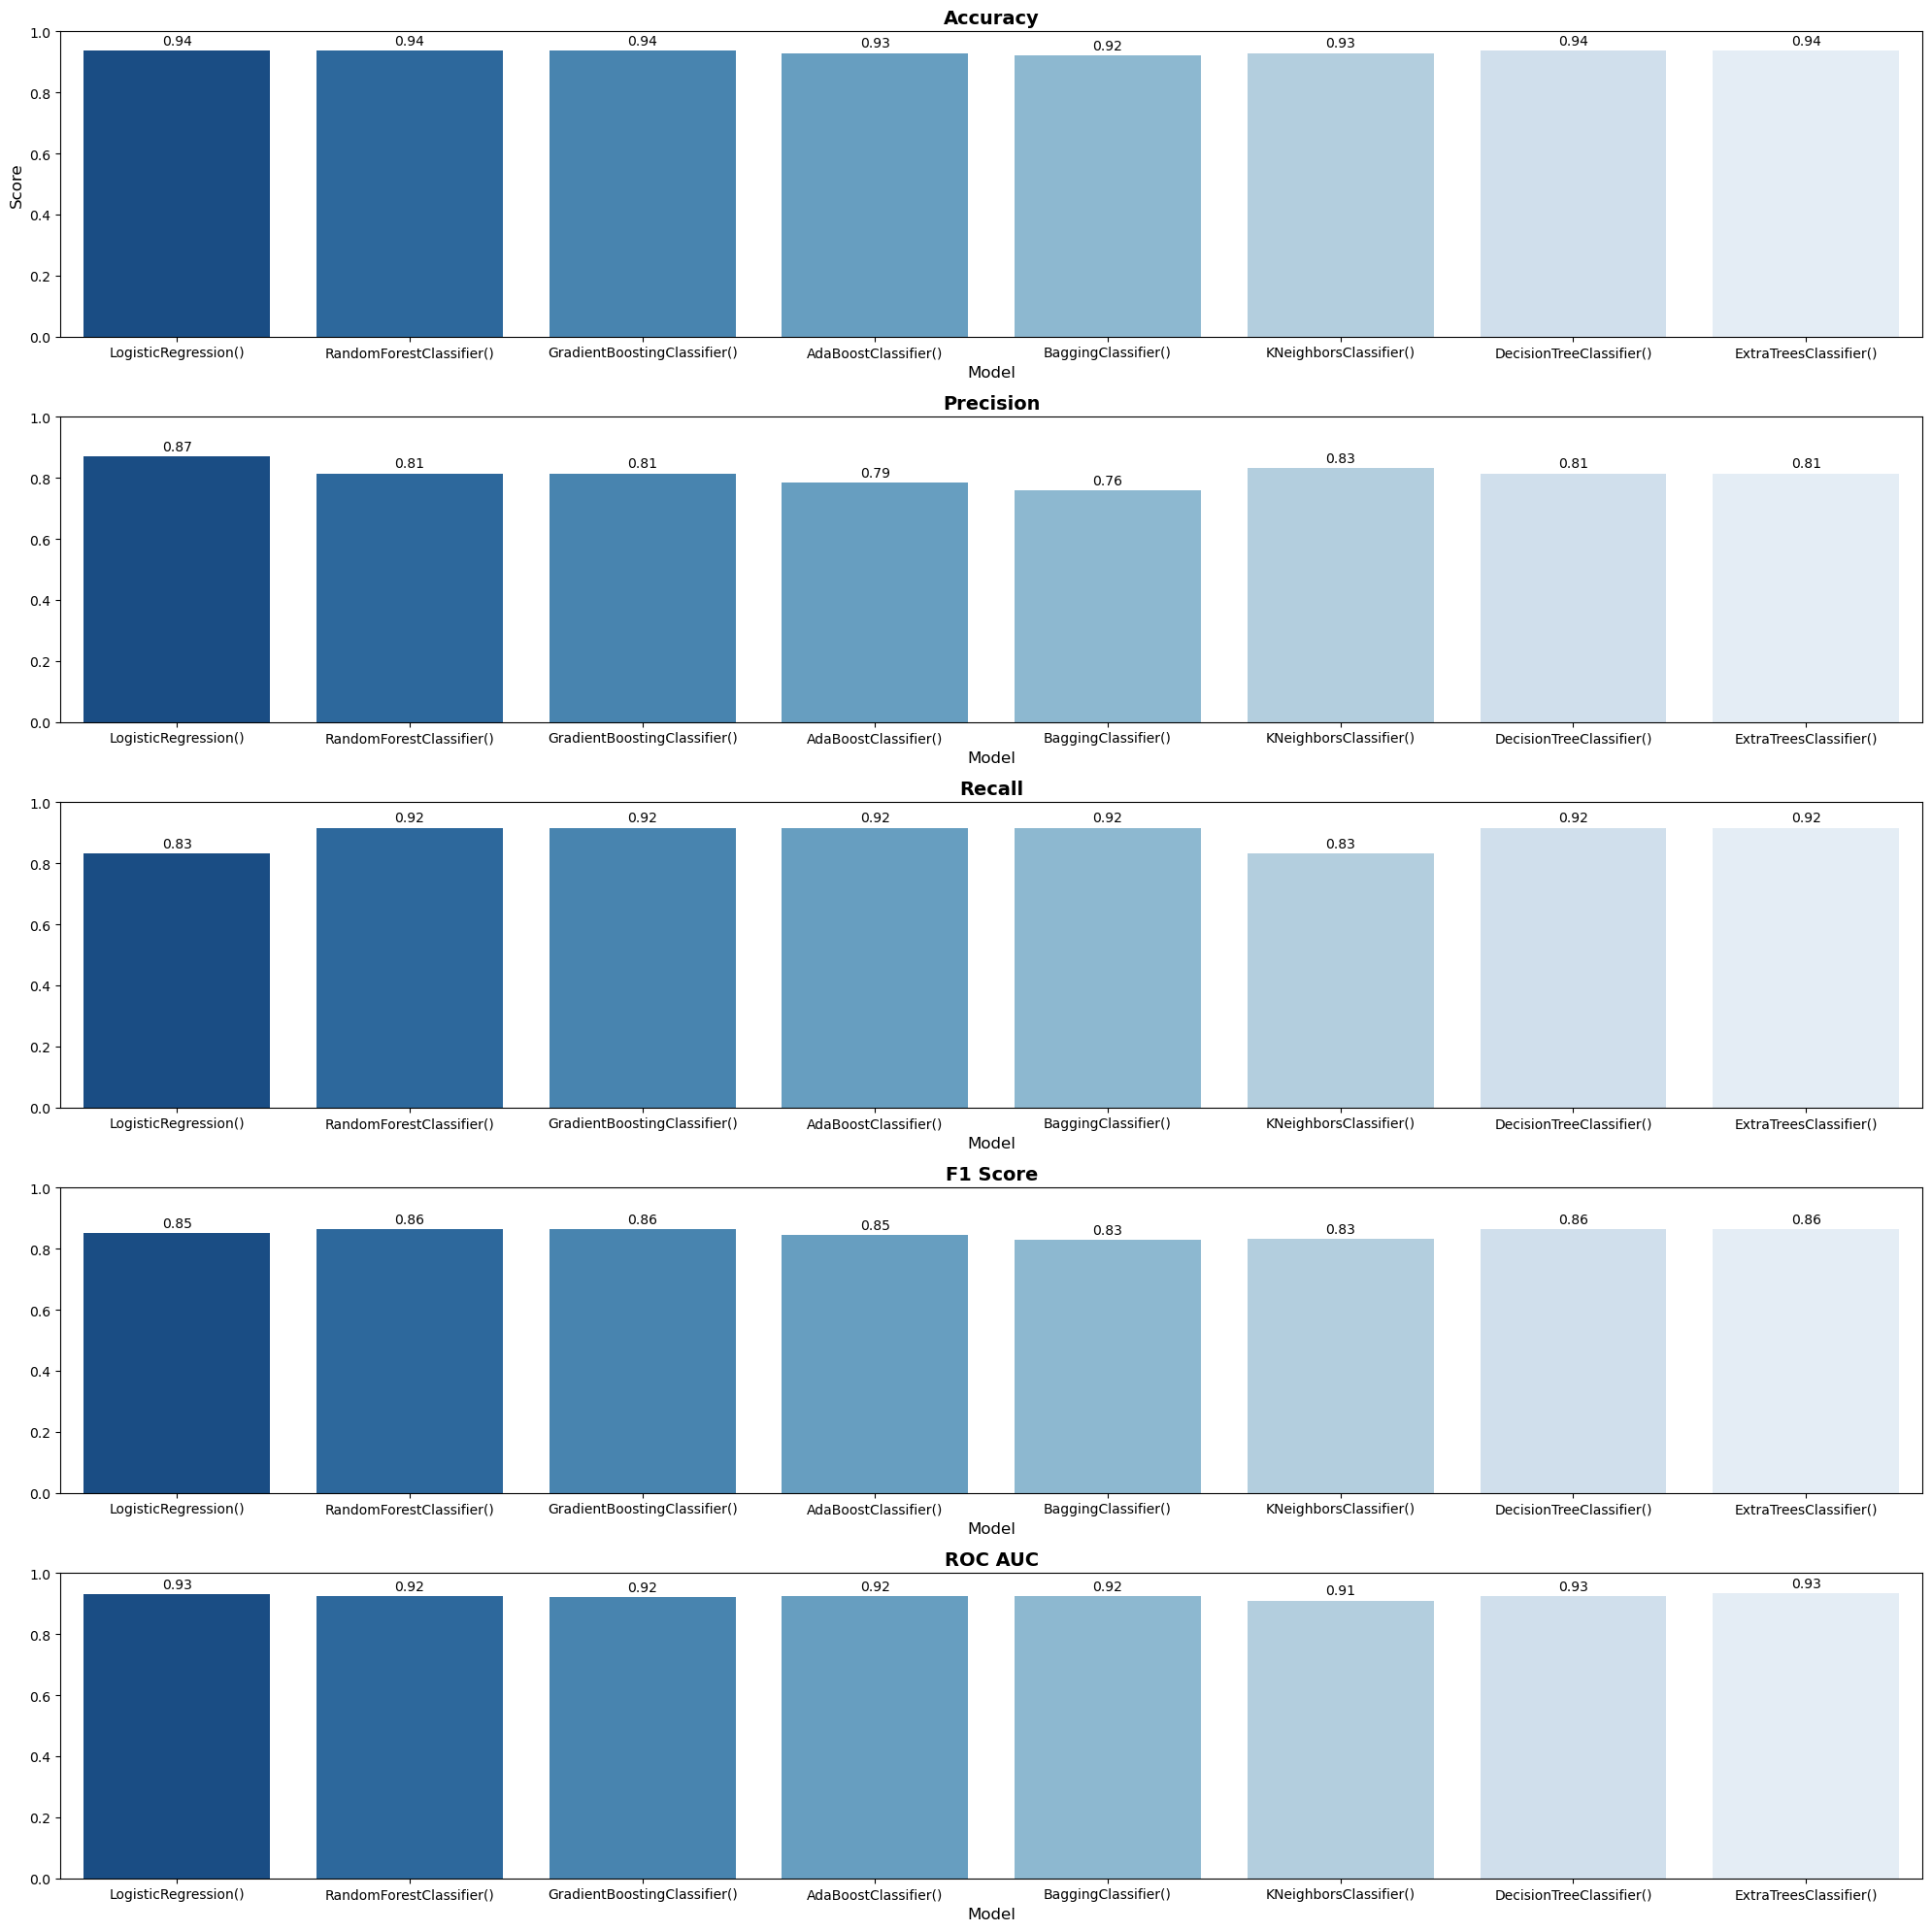

In [48]:
# Prepare data for plotting
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
metric_results = {metric: [] for metric in metrics}

# Collect data for each metric
for model, scores in model_metrics.items():
    for metric in metrics:
        metric_results[metric].append(scores.get(metric, 0))

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(20, 20), sharey=True)

# Plot each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x=list(model_metrics.keys()), y=metric_results[metric], palette="Blues_r", ax=ax)

    # Add labels to the bars
    for j, value in enumerate(metric_results[metric]):
        ax.text(j, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

    # Set labels and title
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylim([0,1])
    ax.set_title(metric, fontsize=14, weight='bold')
    ax.set_xticklabels(ax.get_xticklabels())

# Set common ylabel
axes[0].set_ylabel('Score', fontsize=12)

# Adjust layout
plt.tight_layout()

# Show plot
# plt.savefig('savefig/ClassificationModels.png')
plt.show()


After this shotgun method I decided to further investigate 3 models: Logistic Regressor, Bagging Classifier, and Extra Trees Classifier. First we are gonna start with the Logistic Regressor

## Logistic Regressor

In these deep dives into the 3 models, some more techniques were used to get better results from the models. Those techniques include scaling, SMOTE, and hyperparameter tuning.

In [49]:
# Select only the numeric features you want to scale
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level','Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the numeric features
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# If you want to keep the non-numeric features in the DataFrame
df_scaled = pd.concat([df_scaled, df.drop(columns=numeric_features)], axis=1)

# Display the scaled data
df_scaled.head()


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender,BMI Category,insomnia_binary
0,-1.753096,-1.298887,-1.098280,-0.825418,0.347021,1.654719,-1.619584,-0.330002,-0.268102,1,3,0
1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
2,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
3,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0
4,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0


In [50]:
features = df_scaled.drop(columns='insomnia_binary')
X_scaled = features
y_scaled = df_scaled['insomnia_binary']

In [51]:
oversample = over_sampling.SMOTE()
X_scaled, y_scaled = oversample.fit_resample(X_scaled, y_scaled)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled, test_size=0.3, random_state=36)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=36)

First we started with a baseline to compare the hyperparameters with

In [53]:
# Train the model
model = LogisticRegression(random_state=36)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91        98
           1       0.90      0.89      0.89        81

    accuracy                           0.91       179
   macro avg       0.90      0.90      0.90       179
weighted avg       0.90      0.91      0.90       179

Confusion Matrix:
[[90  8]
 [ 9 72]]


In [54]:
grid = dict()

grid["solver"] = ["newton-cg", "lbfgs", "liblinear"]
grid["penalty"] = ["l2"]
grid["C"] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

The first gridsearch is done with the hope of getting the highest recall possible. I had to slightly adjust this formula as calling 'recall' in the scoring variable will give the recall for the negative variable. 

In [55]:
search = GridSearchCV(estimator=LogisticRegression(random_state=36),
                      param_grid=grid,
                      scoring=recall_scorer,
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		1.0
> OPTIMAL PARAMETERS: 	{'C': 1e-05, 'penalty': 'l2', 'solver': 'newton-cg'}

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.45      1.00      0.62        81

    accuracy                           0.45       179
   macro avg       0.23      0.50      0.31       179
weighted avg       0.20      0.45      0.28       179

Confusion Matrix:
[[ 0 98]
 [ 0 81]]


c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


After getting the ideal recall parameters, I wanted to find the ideal parameters for accuracy, which is seen below

In [56]:
search = GridSearchCV(estimator=LogisticRegression(random_state=36),
                      param_grid=grid,
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		0.8804878048780489
> OPTIMAL PARAMETERS: 	{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        98
           1       0.89      0.89      0.89        81

    accuracy                           0.90       179
   macro avg       0.90      0.90      0.90       179
weighted avg       0.90      0.90      0.90       179

Confusion Matrix:
[[89  9]
 [ 9 72]]


And lastly, the ideal parameters for 'precision' 

In [57]:
search = GridSearchCV(estimator=LogisticRegression(random_state=36),
                      param_grid=grid,
                      scoring='precision',
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		0.8912365734619515
> OPTIMAL PARAMETERS: 	{'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        98
           1       0.89      0.89      0.89        81

    accuracy                           0.90       179
   macro avg       0.90      0.90      0.90       179
weighted avg       0.90      0.90      0.90       179

Confusion Matrix:
[[89  9]
 [ 9 72]]


## Bagging Classifier

I then repeated the process for the Bagging Classifier which can be seen in the following steps, the only thing that was changed was the hyperparameter grid used for the GridSearch

In [58]:
# Select only the numeric features you want to scale
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level','Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the numeric features
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# If you want to keep the non-numeric features in the DataFrame
df_scaled = pd.concat([df_scaled, df.drop(columns=numeric_features)], axis=1)

# Display the scaled data
df_scaled.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender,BMI Category,insomnia_binary
0,-1.753096,-1.298887,-1.098280,-0.825418,0.347021,1.654719,-1.619584,-0.330002,-0.268102,1,3,0
1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
2,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
3,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0
4,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0


In [59]:
features = df_scaled.drop(columns='insomnia_binary')
X_scaled = features
y_scaled = df_scaled['insomnia_binary']

In [60]:
oversample = over_sampling.SMOTE()
X_scaled, y_scaled = oversample.fit_resample(X_scaled, y_scaled)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled, test_size=0.3, random_state=36)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=36)

In [62]:
# Train the model
model = BaggingClassifier(random_state=36)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        98
           1       0.95      0.91      0.93        81

    accuracy                           0.94       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.94      0.94      0.94       179

Confusion Matrix:
[[94  4]
 [ 7 74]]


In [63]:
param_grid_bc = {
    'estimator': [None, DecisionTreeClassifier(max_depth=5), DecisionTreeClassifier(max_depth=10)],
    'n_estimators': [10, 50, 100],  # Number of base estimators
    'max_samples': [0.5, 0.7, 1.0],  # Fraction of samples to draw from X to train each base estimator
    'max_features': [0.5, 0.7, 1.0],  # Fraction of features to draw from X to train each base estimator
    'bootstrap': [True, False],  # Whether to use bootstrap samples
    'bootstrap_features': [True, False],  # Whether to use bootstrap samples for features
    'n_jobs': [-1]  # Number of jobs to run in parallel
}

In [64]:
search = GridSearchCV(estimator=BaggingClassifier(random_state=36),
                      param_grid=param_grid_bc,
                      scoring=recall_scorer,
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		0.91263135514172
> OPTIMAL PARAMETERS: 	{'bootstrap': True, 'bootstrap_features': True, 'estimator': DecisionTreeClassifier(max_depth=5), 'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 50, 'n_jobs': -1}

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        98
           1       0.95      0.91      0.93        81

    accuracy                           0.94       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.94      0.94      0.94       179

Confusion Matrix:
[[94  4]
 [ 7 74]]


In [65]:
search = GridSearchCV(estimator=BaggingClassifier(random_state=36),
                      param_grid=param_grid_bc,
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		0.9365660085172282
> OPTIMAL PARAMETERS: 	{'bootstrap': False, 'bootstrap_features': False, 'estimator': None, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100, 'n_jobs': -1}

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        98
           1       0.95      0.93      0.94        81

    accuracy                           0.94       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.94      0.94      0.94       179

Confusion Matrix:
[[94  4]
 [ 6 75]]


In [66]:
search = GridSearchCV(estimator=BaggingClassifier(random_state=36),
                      param_grid=param_grid_bc,
                      scoring='precision',
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

> BEST SCORE: 		0.9687343320519387
> OPTIMAL PARAMETERS: 	{'bootstrap': False, 'bootstrap_features': True, 'estimator': DecisionTreeClassifier(max_depth=10), 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': -1}

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        98
           1       0.95      0.91      0.93        81

    accuracy                           0.94       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.94      0.94      0.94       179

Confusion Matrix:
[[94  4]
 [ 7 74]]


## Extra Trees Classifier

Similar to the Bagging Classifier, this is the same process as the Logistic Regressor, with the only difference being in the grid used for the GridSearch. 

In [67]:
# Select only the numeric features you want to scale
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level','Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the numeric features
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# If you want to keep the non-numeric features in the DataFrame
df_scaled = pd.concat([df_scaled, df.drop(columns=numeric_features)], axis=1)

# Display the scaled data
df_scaled.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender,BMI Category,insomnia_binary
0,-1.753096,-1.298887,-1.098280,-0.825418,0.347021,1.654719,-1.619584,-0.330002,-0.268102,1,3,0
1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
2,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
3,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0
4,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0


In [68]:
features = df_scaled.drop(columns='insomnia_binary')
X_scaled = features
y_scaled = df_scaled['insomnia_binary']

In [69]:
oversample = over_sampling.SMOTE()
X_scaled, y_scaled = oversample.fit_resample(X_scaled, y_scaled)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y_scaled, test_size=0.3, random_state=36)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=36)

In [71]:
# Train the model
model = ExtraTreesClassifier(random_state=36)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        98
           1       0.95      0.94      0.94        81

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179

Confusion Matrix:
[[94  4]
 [ 5 76]]


In [72]:
param_grid_etc = {
    'n_estimators': [50, 100, 200],         # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider for the best split
    'max_depth': [None, 10, 20, 30],        # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],         # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],           # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],              # Whether to use bootstrap samples
    'n_jobs': [-1]                           # Number of jobs to run in parallel
}

In [73]:
search = GridSearchCV(estimator=ExtraTreesClassifier(random_state=36),
                      param_grid=param_grid_etc,
                      scoring=recall_scorer,
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
6480 fits failed out of a total of 19440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4159 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(


> BEST SCORE: 		0.9315050650825205
> OPTIMAL PARAMETERS: 	{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200, 'n_jobs': -1}

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94        98
           1       0.95      0.91      0.93        81

    accuracy                           0.94       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.94      0.94      0.94       179

Confusion Matrix:
[[94  4]
 [ 7 74]]


In [74]:
search = GridSearchCV(estimator=ExtraTreesClassifier(random_state=36),
                      param_grid=param_grid_etc,
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
6480 fits failed out of a total of 19440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2269 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(


> BEST SCORE: 		0.9421409214092141
> OPTIMAL PARAMETERS: 	{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        98
           1       0.95      0.94      0.94        81

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179

Confusion Matrix:
[[94  4]
 [ 5 76]]


In [75]:
search = GridSearchCV(estimator=ExtraTreesClassifier(random_state=36),
                      param_grid=param_grid_etc,
                      scoring='precision',
                      n_jobs=-1,
                      cv=cv)

result = search.fit(X_train, y_train)

print("> BEST SCORE: \t\t{}".format(result.best_score_))
print("> OPTIMAL PARAMETERS: \t{}".format(result.best_params_))

best_model = result.best_estimator_
y_pred = best_model.predict(X_test)

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
6480 fits failed out of a total of 19440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4222 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\Shank\anaconda3\envs\dsenv\lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(


> BEST SCORE: 		0.9666540190539382
> OPTIMAL PARAMETERS: 	{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1}

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        98
           1       0.95      0.94      0.94        81

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179

Confusion Matrix:
[[94  4]
 [ 5 76]]


_________

# Model Tuning

Now that I got a good understanding for which models are ideal to use for this model, I am going to adjust the features and tuning of it to get the model to perform exactly how I want it to

A lot of the steps that were seen in the hyperparameter tuning steps are reused here with the main addition being the use of LDA/PCA and a threshold when determining which binary variable the predicted value belongs in.

In [77]:
# Select only the numeric features you want to scale
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level','Stress Level', 'Heart Rate', 'Daily Steps', 'Systolic', 'Diastolic']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the numeric features
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# If you want to keep the non-numeric features in the DataFrame
df_scaled = pd.concat([df_scaled, df.drop(columns=numeric_features)], axis=1)

# Display the scaled data
df_scaled.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender,BMI Category,insomnia_binary
0,-1.753096,-1.298887,-1.098280,-0.825418,0.347021,1.654719,-1.619584,-0.330002,-0.268102,1,3,0
1,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
2,-1.637643,-1.173036,-1.098280,0.039844,1.475592,1.170474,1.970077,-0.459239,-0.755640,1,0,0
3,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0
4,-1.637643,-1.550588,-2.771424,-1.402260,1.475592,3.591698,-2.362273,1.479309,0.869486,1,2,0


In [78]:
features = df_scaled.drop(columns=['insomnia_binary', 'Heart Rate', 'Gender', 'BMI Category'])
X_scaled = features
y_scaled = df_scaled['insomnia_binary']

In [79]:
oversample = over_sampling.SMOTE()
X, y = oversample.fit_resample(X_scaled, y_scaled)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=36)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=36)

In [81]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [82]:
model = ExtraTreesClassifier(bootstrap=False, 
                             max_depth=None, 
                             max_features='sqrt', 
                             min_samples_leaf=1, 
                             min_samples_split=2, 
                             n_estimators=200, 
                             n_jobs=-1,
                             random_state=36)

model.fit(X_train_pca,y_train)
y_pred = model.predict(X_test_pca)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


# Predict probabilities to adjust the decision threshold
y_pred_proba = model.predict_proba(X_test_pca)[:, 1]

# Adjust the threshold (lower threshold increases sensitivity to positives)
threshold = 0.1
y_pred_thres = (y_pred_proba >= threshold).astype(int)

# Evaluate the model
print("Confusion Matrix w/Threshold:")
print(confusion_matrix(y_test, y_pred_thres))
print("\nClassification Report w/Threshold:")
print(classification_report(y_test, y_pred_thres))
print("\nAccuracy Score w/Threshold:")
print(accuracy_score(y_test, y_pred_thres))

Confusion Matrix:
[[94  4]
 [ 5 76]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        98
           1       0.95      0.94      0.94        81

    accuracy                           0.95       179
   macro avg       0.95      0.95      0.95       179
weighted avg       0.95      0.95      0.95       179


Accuracy Score:
0.9497206703910615
Confusion Matrix w/Threshold:
[[85 13]
 [ 4 77]]

Classification Report w/Threshold:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91        98
           1       0.86      0.95      0.90        81

    accuracy                           0.91       179
   macro avg       0.91      0.91      0.90       179
weighted avg       0.91      0.91      0.91       179


Accuracy Score w/Threshold:
0.9050279329608939


# The Pipeline

In [83]:
# Define the numeric features for scaling
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                    'Stress Level', 'Daily Steps', 'Systolic', 'Diastolic']

In [84]:
# Define the preprocessing step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ], remainder='passthrough')

In [85]:
# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=3)),
    ('model', ExtraTreesClassifier(bootstrap=False, 
                                   max_depth=None, 
                                   max_features='sqrt', 
                                   min_samples_leaf=1, 
                                   min_samples_split=2, 
                                   n_estimators=200, 
                                   n_jobs=-1,
                                   random_state=36))
])

In [86]:
# Separate features and target variable
features = df.drop(columns=['insomnia_binary', 'Heart Rate', 'Gender', 'BMI Category'])
X_scaled = features
y_scaled = df['insomnia_binary']


In [87]:
# Apply SMOTE for oversampling
oversample = SMOTE(random_state=36)
X, y = oversample.fit_resample(X_scaled, y_scaled)

In [88]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=36)

In [89]:
X_train.head()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Daily Steps,Systolic,Diastolic
498,43,6.5,6,45,7,6000,130,85
346,57,8.2,9,75,3,7000,140,95
67,33,6.0,6,30,8,5000,125,80
516,44,6.3,6,45,7,6000,130,85
561,44,6.4,6,45,7,6000,130,85


In [90]:
# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

Confusion Matrix:
[[94  4]
 [ 6 75]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        98
           1       0.95      0.93      0.94        81

    accuracy                           0.94       179
   macro avg       0.94      0.94      0.94       179
weighted avg       0.94      0.94      0.94       179


Accuracy Score:
0.9441340782122905


In [91]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict probabilities using the pipeline
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Adjust the threshold
threshold = 0.08
y_pred_thres = (y_pred_proba >= threshold).astype(int)

# Evaluate the model with the adjusted threshold
print("Confusion Matrix w/Threshold:")
print(confusion_matrix(y_test, y_pred_thres))
print("\nClassification Report w/Threshold:")
print(classification_report(y_test, y_pred_thres))
print("\nAccuracy Score w/Threshold:")
print(accuracy_score(y_test, y_pred_thres))

Confusion Matrix w/Threshold:
[[81 17]
 [ 3 78]]

Classification Report w/Threshold:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        98
           1       0.82      0.96      0.89        81

    accuracy                           0.89       179
   macro avg       0.89      0.89      0.89       179
weighted avg       0.90      0.89      0.89       179


Accuracy Score w/Threshold:
0.888268156424581


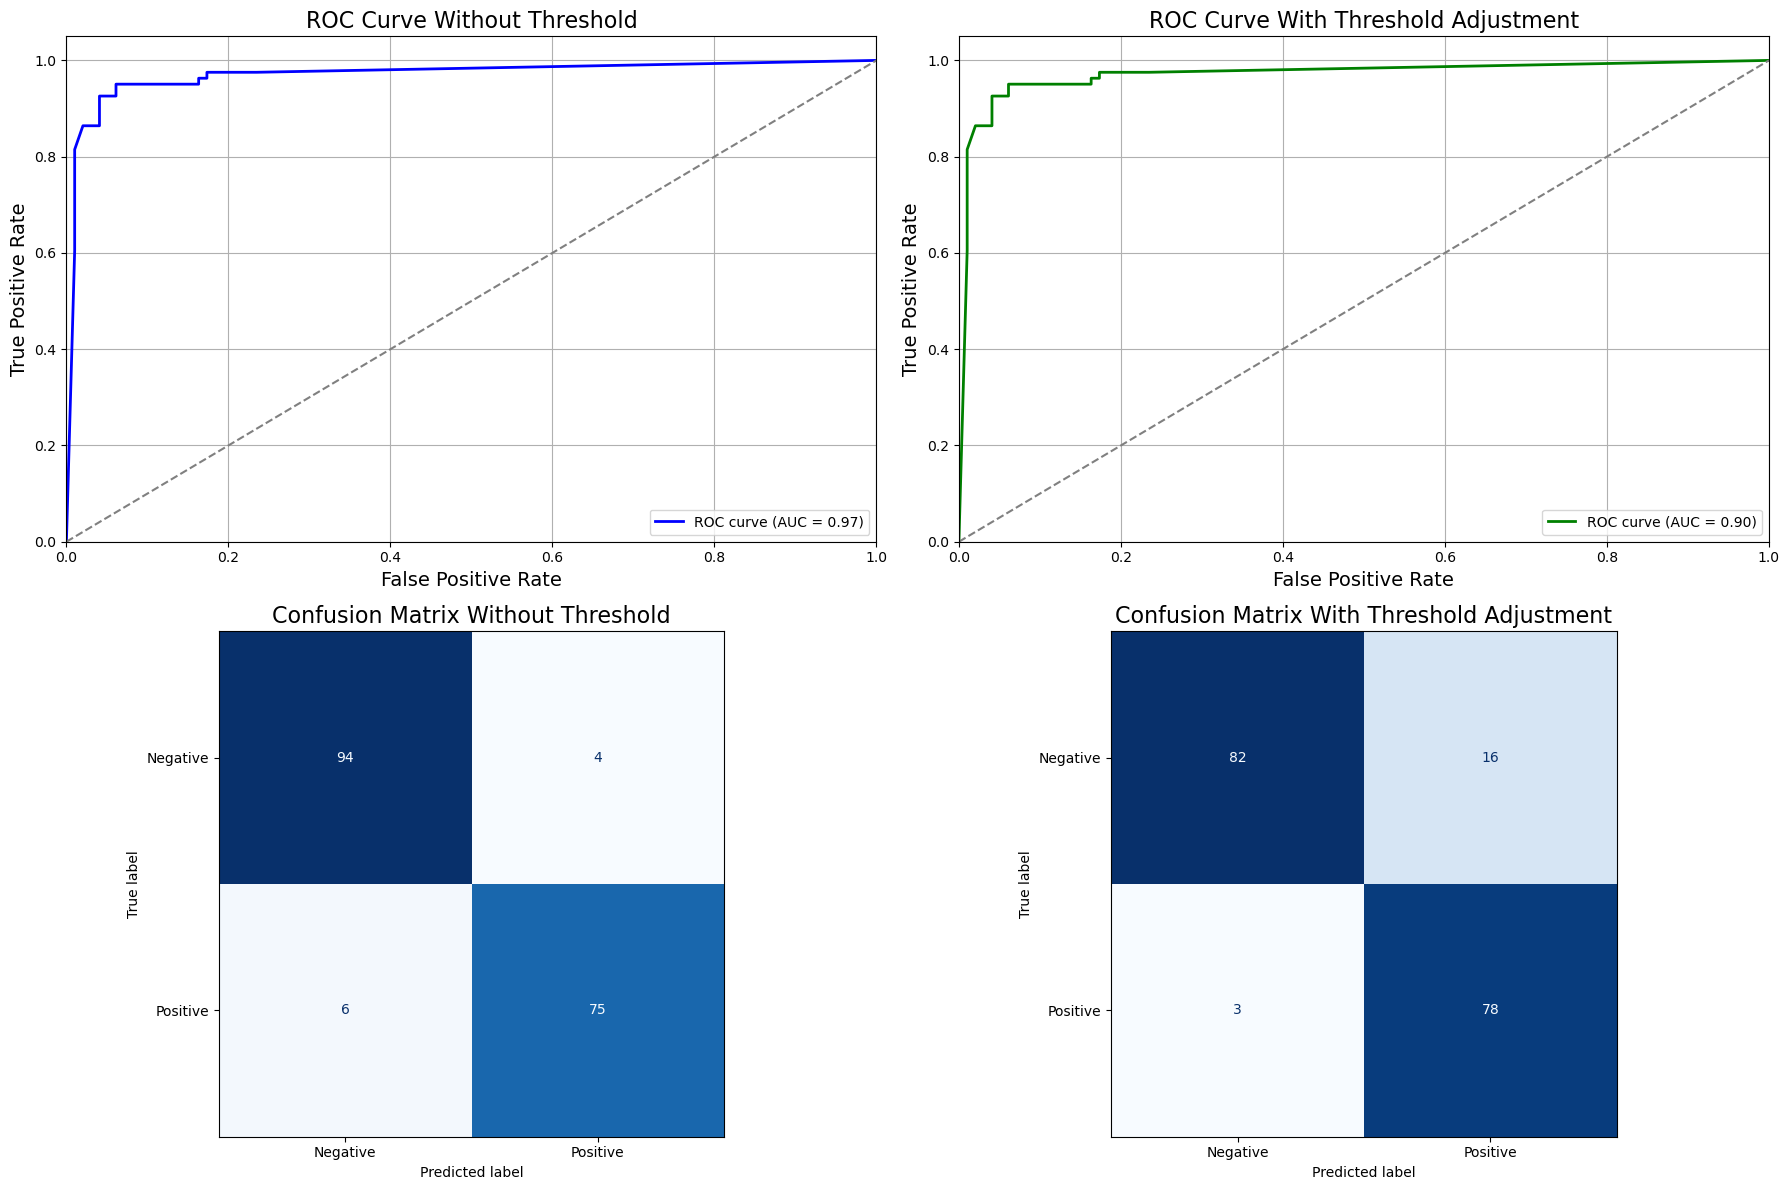

In [92]:
# Predict probabilities and predictions using the pipeline
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)

# Compute ROC curve without threshold adjustment
fpr_no_thresh, tpr_no_thresh, _ = roc_curve(y_test, y_pred_proba)
roc_auc_no_thresh = roc_auc_score(y_test, y_pred_proba)

# Adjust the threshold
threshold = 0.1
y_pred_thres = (y_pred_proba >= threshold).astype(int)

# Compute ROC curve with threshold adjustment
fpr_thresh, tpr_thresh, _ = roc_curve(y_test, y_pred_proba)
roc_auc_thresh = roc_auc_score(y_test, y_pred_thres)

# Compute confusion matrices
conf_matrix_no_thresh = confusion_matrix(y_test, y_pred)
conf_matrix_thresh = confusion_matrix(y_test, y_pred_thres)

# Create subplots for ROC curves and confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot ROC curve without threshold adjustment
axes[0, 0].plot(fpr_no_thresh, tpr_no_thresh, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc_no_thresh:.2f})')
axes[0, 0].plot([0, 1], [0, 1], color='grey', linestyle='--')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate', fontsize=14)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=14)
axes[0, 0].set_title('ROC Curve Without Threshold', fontsize=16)
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(True)

# Plot ROC curve with threshold adjustment
axes[0, 1].plot(fpr_thresh, tpr_thresh, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc_thresh:.2f})')
axes[0, 1].plot([0, 1], [0, 1], color='grey', linestyle='--')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate', fontsize=14)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=14)
axes[0, 1].set_title('ROC Curve With Threshold Adjustment', fontsize=16)
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(True)

# Plot confusion matrix without threshold adjustment
disp_no_thresh = ConfusionMatrixDisplay(conf_matrix_no_thresh, display_labels=['Negative', 'Positive'])
disp_no_thresh.plot(ax=axes[1, 0], cmap='Blues', colorbar=False, values_format='d')
axes[1, 0].set_title('Confusion Matrix Without Threshold', fontsize=16)

# Plot confusion matrix with threshold adjustment
disp_thresh = ConfusionMatrixDisplay(conf_matrix_thresh, display_labels=['Negative', 'Positive'])
disp_thresh.plot(ax=axes[1, 1], cmap='Blues', colorbar=False, values_format='d')
axes[1, 1].set_title('Confusion Matrix With Threshold Adjustment', fontsize=16)

plt.tight_layout()
plt.show()


# Final Pipeline

This first cell of code is simply to use the pipeline and evaluate the feature importance. With the final pipeline, PCA is used and therefore feauture importance would not be legible to the human reader.

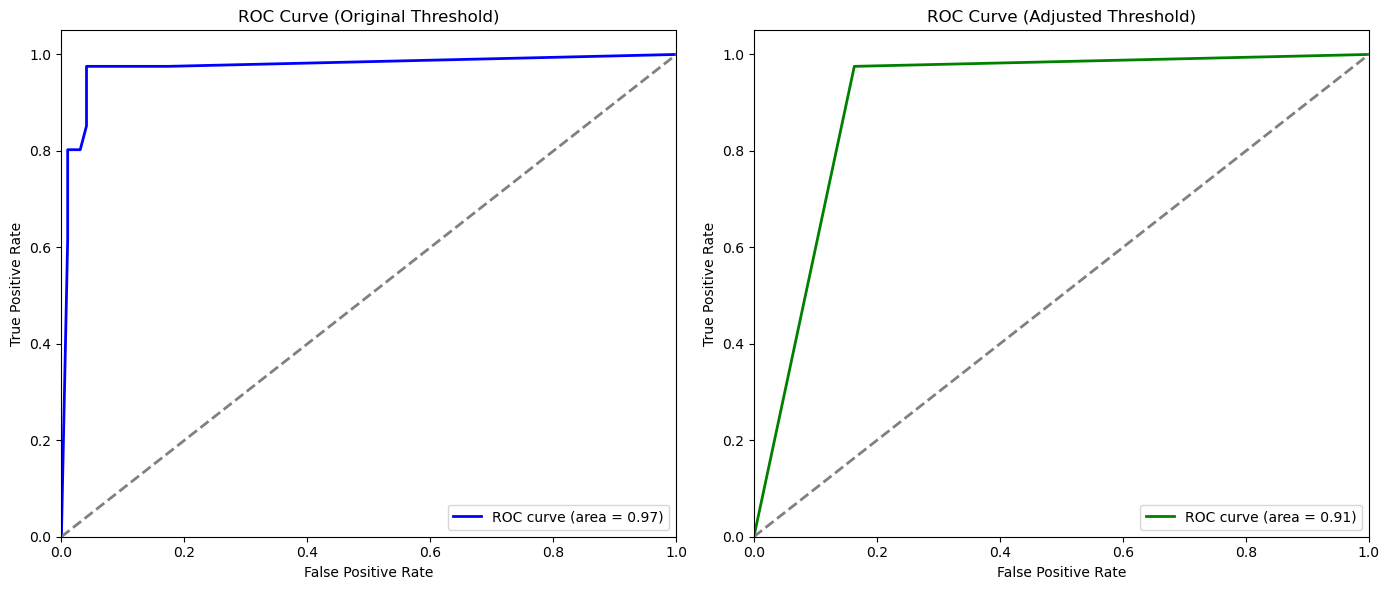

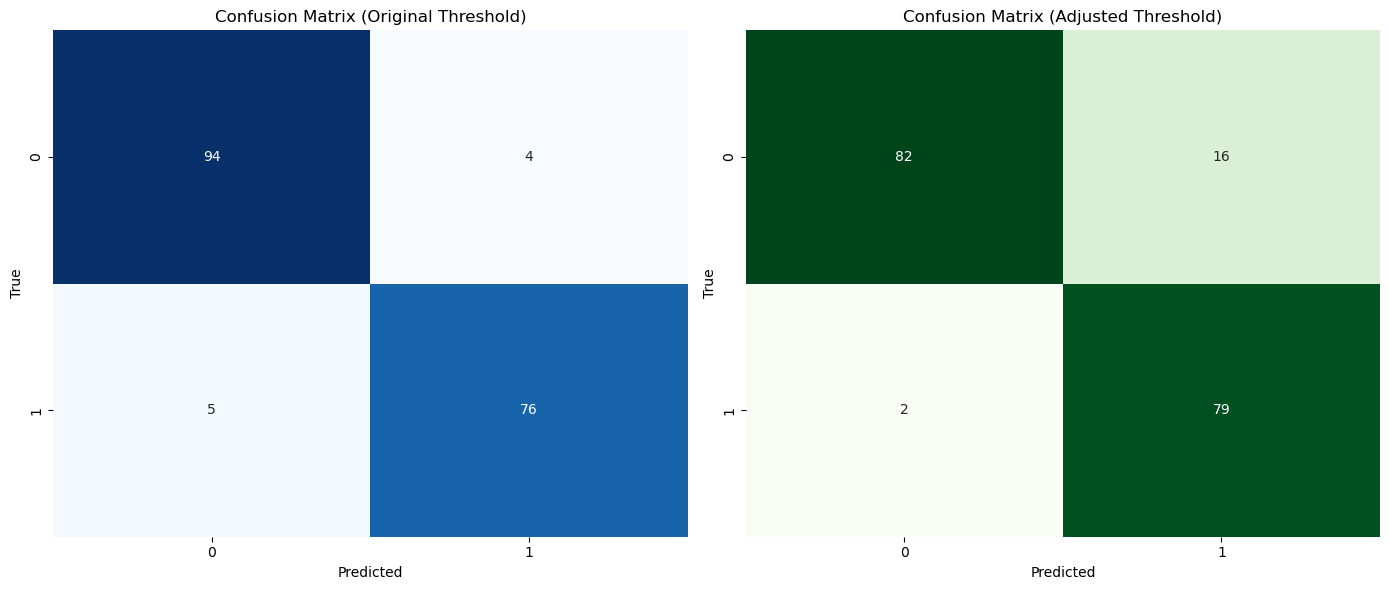

In [100]:
# Additional preprocessing steps
label_encoder = LabelEncoder()
for column in ['Gender', 'BMI Category']:
    df[column] = label_encoder.fit_transform(df[column])

# Defining the features and target variable
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                    'Stress Level', 'Daily Steps', 'Systolic', 'Diastolic', 'Gender', 'BMI Category']
X = df[numeric_features]
y = df['insomnia_binary']

# Creating the model pipeline (without scaling and PCA)
pipeline = Pipeline(steps=[
    ('model', ExtraTreesClassifier(bootstrap=False, 
                                   max_depth=None, 
                                   max_features='sqrt', 
                                   min_samples_leaf=1, 
                                   min_samples_split=2, 
                                   n_estimators=200, 
                                   n_jobs=-1,
                                   random_state=36))
])

# Applying SMOTE for oversampling
oversample = SMOTE(random_state=36)
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=36)

# Fitting the pipeline
pipeline.fit(X_train, y_train)

# Predicting probabilities to adjust the decision threshold
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Adjusting the threshold (lower threshold increases sensitivity to positives)
threshold = 0.1
y_pred_thres = (y_pred_proba >= threshold).astype(int)

# Plotting ROC curves
plt.figure(figsize=(14, 6))

# ROC curve without threshold adjustment
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Original Threshold)')
plt.legend(loc="lower right")

# ROC curve with threshold adjustment
fpr_thres, tpr_thres, _ = roc_curve(y_test, y_pred_thres)
roc_auc_thres = auc(fpr_thres, tpr_thres)
plt.subplot(1, 2, 2)
plt.plot(fpr_thres, tpr_thres, color='green', lw=2, label=f'ROC curve (area = {roc_auc_thres:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Adjusted Threshold)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Plotting confusion matrices
plt.figure(figsize=(14, 6))

# Confusion matrix without threshold adjustment
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, pipeline.predict(X_test)), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix (Original Threshold)')
plt.xlabel('Predicted')
plt.ylabel('True')

# Confusion matrix with threshold adjustment
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_thres), annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title('Confusion Matrix (Adjusted Threshold)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


Lets get those feature importance

                   Feature  Importance
9             BMI Category    0.198981
1           Sleep Duration    0.140376
3  Physical Activity Level    0.137363
6                 Systolic    0.106986
7                Diastolic    0.092348
5              Daily Steps    0.086776
2         Quality of Sleep    0.078387
0                      Age    0.075668
4             Stress Level    0.065221
8                   Gender    0.017893


C:\Users\Shank\AppData\Local\Temp\ipykernel_13812\2875797531.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')


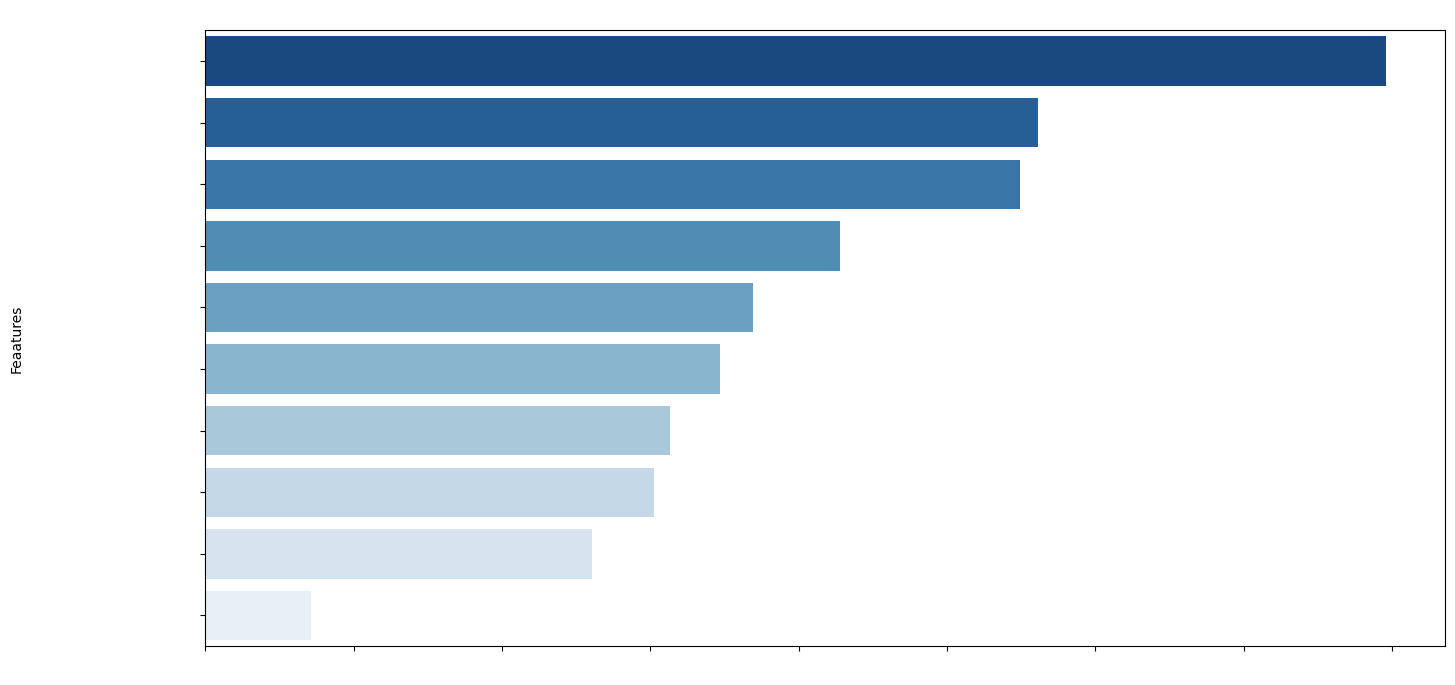

In [105]:
# Extracting the feature importances from the model
feature_importances = pipeline.named_steps['model'].feature_importances_

# Creating a DataFrame to display the feature importances
importance_df = pd.DataFrame({
    'Feature': numeric_features,
    'Importance': feature_importances
})

# Sorting the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Displaying the feature importances
print(importance_df)

# Plotting the feature importances
plt.figure(figsize=(16, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')
plt.title('Feature Importance', fontsize=16, color='white')
plt.xlabel('')
plt.ylabel('Feaatures')
plt.yticks(fontsize=14, color='white', rotation=45, ha='right')
plt.xticks(fontsize=14, color='white')
plt.title('Feature Importances')
plt.savefig('feature_importances.png', transparent=True)
plt.show()


This is THE FINAL PIPELINE!!

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90        98
           1       0.84      0.96      0.90        81

    accuracy                           0.90       179
   macro avg       0.90      0.90      0.90       179
weighted avg       0.91      0.90      0.90       179



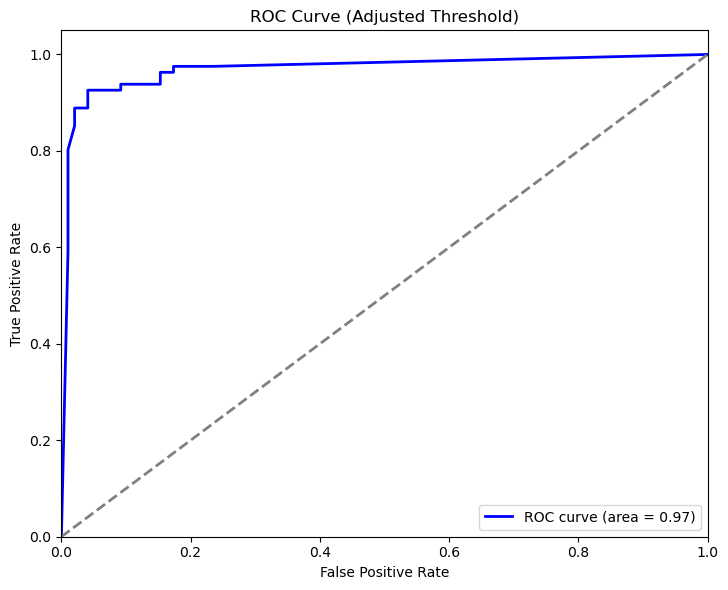

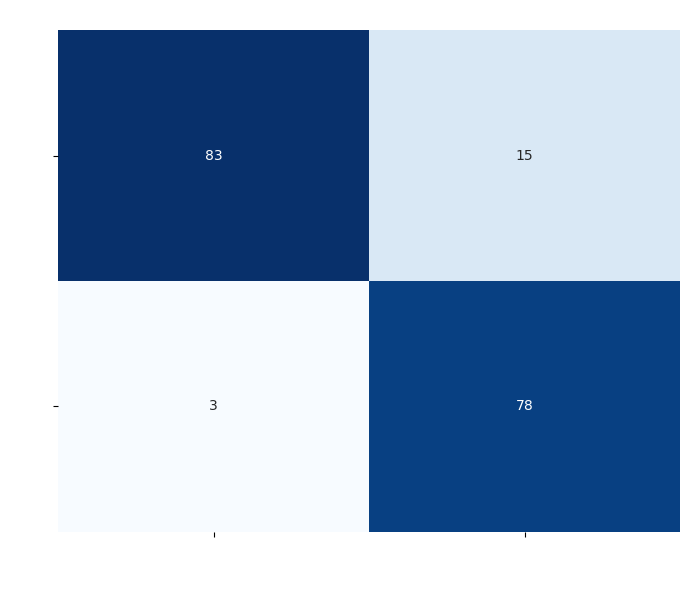

In [107]:
# Additional preprocessing steps
label_encoder = LabelEncoder()
for column in ['Gender', 'BMI Category']:
    df[column] = label_encoder.fit_transform(df[column])

# Defining the features and target variable
numeric_features = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 
                    'Stress Level', 'Daily Steps', 'Systolic', 'Diastolic', 'BMI Category']
X = df[numeric_features]
y = df['insomnia_binary']

# Creating the pipeline with scaler, PCA, and model
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('model', ExtraTreesClassifier(bootstrap=False, 
                                   max_depth=None, 
                                   max_features='sqrt', 
                                   min_samples_leaf=1, 
                                   min_samples_split=2, 
                                   n_estimators=200, 
                                   n_jobs=-1,
                                   random_state=36))
])

# Applying SMOTE for oversampling
oversample = SMOTE(random_state=36)
X_resampled, y_resampled = oversample.fit_resample(X, y)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=36)

# Fitting the pipeline
pipeline.fit(X_train, y_train)

# Predicting probabilities to adjust the decision threshold
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Adjusting the threshold (lower threshold increases sensitivity to positives)
threshold = 0.1
y_pred_thres = (y_pred_proba >= threshold).astype(int)

report = classification_report(y_test, y_pred_thres)
print("Classification Report:")
print(report)

# Plotting ROC curve with threshold adjustment
plt.figure(figsize=(14, 6))

# ROC curve with threshold adjustment
fpr_thres, tpr_thres, _ = roc_curve(y_test, y_pred_proba)
roc_auc_thres = auc(fpr_thres, tpr_thres)
plt.subplot(1, 2, 1)
plt.plot(fpr_thres, tpr_thres, color='b', lw=2, label=f'ROC curve (area = {roc_auc_thres:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Adjusted Threshold)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Plotting confusion matrix with threshold adjustment
plt.figure(figsize=(7, 6))

# Confusion matrix with threshold adjustment
sns.heatmap(confusion_matrix(y_test, y_pred_thres), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix', color='white')
plt.xlabel('Predicted', color='white')
plt.ylabel('True', color='white')
plt.yticks(fontsize=14, color='white')
plt.xticks(fontsize=14, color='white')
plt.savefig('Confusion_Matrix.png', transparent=True)
plt.tight_layout()
plt.show()


# Summery

My model creation has many steps in the process so lets look at each one step by step

#### Step 1: Cleaning and Preprocessing
#### Step 2: Shotgun Method
#### Step 3: GridSearch
#### Step 4: Building the Pipeline
#### Step 5: Finalizing the Pipeline

## Step 1: Cleaning and Preprocessing

Data cleaning and preprocessing, in this stage, its all about getting the dataset ready to be tested on. There were multiple columns that in their raw form are simply unable to be interpretted by a machine learning model. This step is designed to make each and every column in my dataset legible for my model. 

## Step 2: Shotgun Method

The shotgun method is designed to get a preliminary idea of which models are best for our dataset by testing a bunch of different models. For this dataset, I tested 8 different model. I tested the following
- Logistic Regressor
- Random Forest Classsifier
- Gradient Boosting Classifier
- AdaBoosting Classifier
- Bagging Classifier
- KNeighbors Classifier
- Decision Tree Classifier
- Extra Trees Classifier

Out of these 8, I got relatively similar scores for 3 of the models that being Logistic Regressor, Bagging Classifier and Extra Trees Classifier which are all included in the next step

## Step 3: GridSearch

This step was designed to get a better idea of which model performed the best. Unlike the shotgun method, this step included better reports on the models such as classification reports and confusion matricies. Also new in this step was the implementation of SMOTE, to balance out the classes being tested upon, and scaling, in order to create a more even weighting across the features and lastly hyperparameter grids earches, these gridsearches go through thousadns of possible parameter combinations and pick out the best performing combination for the scoring metric given. Because I am extra, I decided to do 3 different scoring metric for each of the models. A metric based on overall accuracy, precision and recall.

To me, recall was the most important metric. If i was able to maximize recall without jepardizing the overall accuracy of my model then I would consider that a job well done as that would people that very few patients with insomnia would go undiagnosed. The easy way to do that is to say that everyone has insomnia but that would result in a severe decrease in accuracy. So my goal from here was to find the best tradeoff between accuracy and recall

## Step 4: Building the Pipeline
During the GridSearch Step, I would that Extra Trees Classifier had the best scores when predicting so that is what i am going to use for the remainder of my model. 

In this step I took what I found the be the top Extra Trees Classifier paramaters of my notebook thus far and added all the preprocessing method Ive done so far in combination with an addition of PCA (dimensionality reduction) and the addition of a threshold reducer. The idea with both is that I can make it a little bit easier for my model to correctly predict whether a patient has insomnia or not. 

After this step was complete I was relatively happy with my results andfelt confident finalizing my pipeline with everything in one.

## Step 5: Finalizing the Pipeline

This was the most straightforward step of teh entire model buidling procress. In this step, I simply copied everything that I found to be an improvement for my model and combined it into a single pipeline. I would consider that fianl pipeline to be my finalized model.

## Conclusion

I think this model still has plenty of room for improvement, ideally I would love to see the recall get to 100% without having the accuracy getting below 80% but I am not sure how feasable that is. While I dont know how applicable my model is in the real world I would love to further study how doctors and other medical professionals go about diagnosing diseases and disorders. 

In [110]:
import nbformat

def generate_toc(notebook_path):
    with open(notebook_path) as f:
        nb = nbformat.read(f, as_version=4)
    
    toc = []
    for cell in nb.cells:
        if cell.cell_type == 'markdown':
            lines = cell.source.split('\n')
            for line in lines:
                if line.startswith('#'):
                    header_level = line.count('#')
                    header_text = line.replace('#', '').strip()
                    toc.append((header_level, header_text))
    
    toc_md = ['## Table of Contents']
    for level, text in toc:
        toc_md.append(f"{'    ' * (level - 1)}- [{text}](#{text.replace(' ', '-')})")
    
    return '\n'.join(toc_md)

notebook_path = 'Insomnia Model.ipynb'
toc_md = generate_toc(notebook_path)

# Print the generated TOC
# print(toc_md)